#### Visual Source: https://www.youtube.com/watch?v=4Bdc55j80l8&ab_channel=TheA.I.Hacker-MichaelPhi
#### Implementation Source: https://www.youtube.com/watch?v=U0s0f995w14&ab_channel=AladdinPersson
#### Paper: https://arxiv.org/pdf/1706.03762.pdf

In [11]:
import torch
import torch.nn as nn
import numpy as np

In [28]:
# Self-Attention
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelftAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        # How einsum works ej: M = np.einsum("ik, kj -> ij", A, B)
        # La dimension que se repite es la que se suma
        # Free indices: i,j
        # Summation index: k

        # queries shape: (N, query_len, heads, head_dim)
        # keys shape (N, key_len, heads, head_dim)
        # energy shape: (N, heads, query_len, key_len)
        energy = torch.einsum("nqhd, nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)

        out = toch.einsum("nhql, nlhd -> nqhd", [attention, values]).reshape(N, quert_len, self.heads * self.head_dim)

        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # Important: the key_len and the value_len are the same
        # out shape: (N, query_len, heads, head_dim)

        out = self.fc_out(out)
        return out

#### Transformer block
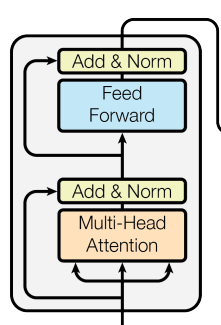

In [30]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        # Llamo a la multihead attention layer
        # Dependiendo donde se use el block el valor de mask varia
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out